In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch

In [4]:
OMNIFALL_ROOT = "/lsdf/data/activity/fall_detection/cvhci_fall"

In [5]:
import random

random.seed(0)

In [6]:
from infreqact.data.video_dataset import OmnifallVideoDataset

dataset_config = {
    "video_root": f"{OMNIFALL_ROOT}/OOPS/video",
    "annotations_file": "hf://simplexsigil2/omnifall/labels/OOPS.csv",
    "split_root": "hf://simplexsigil2/omnifall/splits",
    "dataset_name": "OOPS",
    "mode": "test",  # Start with test set (smaller)
    "split": "cs",  # Cross-subject split
    "target_fps": 8.0,  # Low FPS for quick testing
    "vid_frame_count": 8,
    "data_fps": 30.0,  # OOPS videos are 30 FPS
    "ext": ".mp4",
    "fast": True,
    "size": (320, 567),  # Resize frames to 320x567 for faster processing
}

print("\nDataset Configuration:")
for key, value in dataset_config.items():
    print(f"  {key}: {value}")
print("=" * 80)

# Create dataset
print("\nCreating OmnifallVideoDataset...")
try:
    dataset = OmnifallVideoDataset(**dataset_config)
    print("✓ Dataset created successfully!")
    print(f"\n{dataset}")
    print("=" * 80)

except Exception as e:
    print(f"✗ Failed to create dataset: {e}")
    import traceback

    traceback.print_exc()


Dataset Configuration:
  video_root: /lsdf/data/activity/fall_detection/cvhci_fall/OOPS/video
  annotations_file: hf://simplexsigil2/omnifall/labels/OOPS.csv
  split_root: hf://simplexsigil2/omnifall/splits
  dataset_name: OOPS
  mode: test
  split: cs
  target_fps: 8.0
  vid_frame_count: 8
  data_fps: 30.0
  ext: .mp4
  fast: True
  size: (320, 567)

Creating OmnifallVideoDataset...
✓ Dataset created successfully!

OmnifallVideoDataset(name='OOPS', split='cs', mode='test', videos=573, segments=2743)


In [9]:
sample = dataset[0]
sample["video"].shape

torch.Size([8, 3, 320, 567])

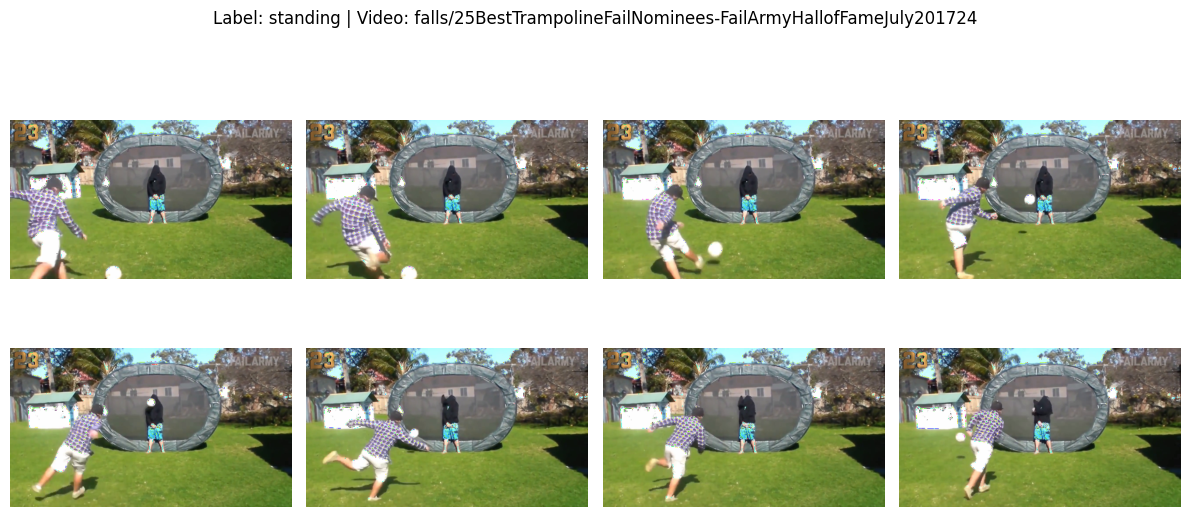

In [10]:
import matplotlib.pyplot as plt

# Get video tensor from sample - shape is (C, T, H, W)
video = sample["video"]

# Convert from (C, T, H, W) to (T, H, W, C) for visualization
frames = video.permute(0, 2, 3, 1).numpy()

# Normalize to 0-255 range if needed
frames = frames.astype("uint8")

# Plot a grid of frames
num_frames = frames.shape[0]
cols = 4
rows = (num_frames + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_frames:
        axes[i].imshow(frames[i])
    axes[i].axis("off")

plt.suptitle(f"Label: {sample['label_str']} | Video: {sample['video_path']}")
plt.tight_layout()
plt.show()

In [11]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model_checkpoint = "Qwen/Qwen3-VL-2B-Thinking"
processor = AutoProcessor.from_pretrained(
    model_checkpoint,
    do_sample_frames=False,
)
model = AutoModelForImageTextToText.from_pretrained(
    model_checkpoint, dtype="bfloat16", device_map="auto", attn_implementation="flash_attention_2"
)

In [12]:
# budget for image processor, since the compression ratio is 32 for Qwen3-VL, we can set the number of visual tokens of a single image to 256-1280 (32× spatial compression)
# processor.image_processor.size = {"longest_edge": 1280*32*32, "shortest_edge": 256*32*32}

# budget for video processor, we can set the number of visual tokens of a single video to 256-16384 (32× spatial compression + 2× temporal compression)
# processor.video_processor.size = {"longest_edge": 16384*32*32*2, "shortest_edge": 256*32*32*2}


In [13]:
from transformers.video_utils import VideoMetadata

metadata = VideoMetadata(
    total_num_frames=len(frames),
    fps=8.0,
    frames_indices=list(range(len(frames))),
)

In [14]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": frames,
            },
            {"type": "text", "text": "Classify the action of the main subject in the video."},
        ],
    }
]
inputs = processor.apply_chat_template(
    messages,
    return_tensors="pt",
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    video_metadata=metadata,
).to(model.device, dtype=torch.float16)

In [15]:
inputs["pixel_values_videos"].shape

torch.Size([2880, 1536])

In [16]:
generated_ids = model.generate(**inputs, max_new_tokens=10000)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
output_text

: 